# Learning rate

What is it? How does it affect the learning process?

In [1]:
%config InlineBackend.figure_formats = ('svg',)
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

try:
    import seaborn as sns
except:
    pass

import fancy_plot

## Least squares function

$$f(x) = x^2$$

$$L = \sum_{x_i, y_i} (y_i - \hat{y_i})^2 = \sum_{x_i, y_i} (y_i - w^Tx_i)^2$$

To simplify the derivative, we will instead take:

$$f(x) = \dfrac{1}{2} x^2 \rightarrow L = \dfrac{1}{2} \sum_{x_i, y_i} (y_i - w^Tx_i)^2$$

In [2]:
def norm(x):
    return 0.5 * (x**2).sum(axis=1)

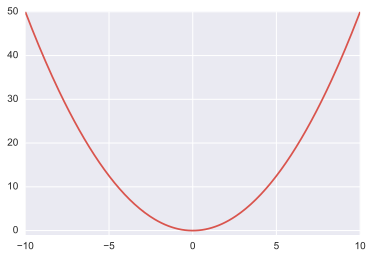

In [3]:
def plot_loss():
    u = np.linspace(-10, 10, 200)
    fig = plt.figure()
    gca = fig.gca()
    y = norm(u.reshape((-1, 1)))
    plt.plot(u, y, fancy_plot.color('pale red'))
    gca.set_ylim((-1, y.max()))
    return gca
    
plot_loss()
plt.show()

## Idea

Suppose we want to find the minimum of the function in an empirical way, that is not solving the linear system. 

We could simply start by a random point $x_0$ and move to a new point $x_1$ so that $f(x_1) < f(x_0)$.

* Try moving 1 unit to the right ($x_1 = x_0 + 1$), if the value is lower, return
* Otherwise, move 1 unit to the left ($x_1 = x_0 - 1$)

Went from 0.838185 to -0.161815


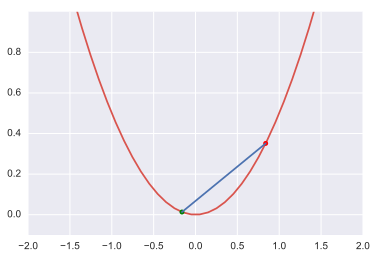

In [4]:
def minimize_step(f, x0):
    # Try moving left
    x1 = x0 + 1
    if f(x1) < f(x0):
        return x1
    
    x1 = x0 - 1
    return x1

x0 = np.random.sample((1,1))
x1 = minimize_step(norm, x0)

print "Went from %f to %f" % (x0, x1)

gca = plot_loss()
plt.plot(x0, norm(x0), 'ro', markersize=5)
plt.plot(x1, norm(x1), 'go', markersize=5)
plt.plot([x0[0], x1[0]], [norm(x0), norm(x1)])
gca.set_ylim((-0.1, 1))
gca.set_xlim((-2, 2))
plt.show()

So what happens if we repeteadly apply this function for $n$ times?

Went from 0.097778 to -0.895230
Went from -0.895230 to 0.106966
Went from 0.106966 to -0.889664
Went from -0.889664 to 0.115796
Went from 0.115796 to -0.876892
Went from -0.876892 to 0.129639
Went from 0.129639 to -0.862984
Went from -0.862984 to 0.139474
Went from 0.139474 to -0.859891
Went from -0.859891 to 0.147871


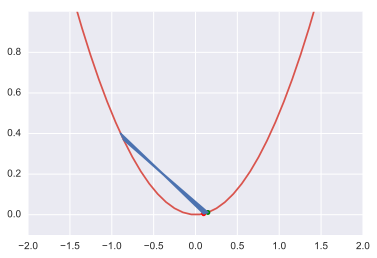

In [5]:
def repeat_minimize(f, n, minimizer=minimize_step):
    x0 = np.random.sample((1,1))
    path = [x0]
    vals = [norm(x0)]
    for _ in range(n):
        # Add some noise for visualization purposes
        x1 = minimizer(f, x0) + 0.01 * np.random.sample(1)
        
        print "Went from %f to %f" % (x0, x1)
        x0 = x1
        
        path.append(x0)
        vals.append(norm(x0))
        
    return np.array(path), np.array(vals)

def plot_repeat(path, vals):
    gca = plot_loss()
    plt.plot(path[0], norm(path[0]), 'ro', markersize=5)
    plt.plot(path[-1], norm(path[-1]), 'go', markersize=5)
    plt.plot(path[:,0], vals[:,0])
    gca.set_ylim((-0.1, 1))
    gca.set_xlim((-2, 2))
    plt.show()
    
path, vals = repeat_minimize(norm, 10)
plot_repeat(path, vals)

## Problem

We can not find the minimum because we are always oscillating... What if instead of always moving 1 unit, we move some prefixef $\alpha$ step that we can tune?

Went from 0.829980 to -0.163259
Went from -0.163259 to -1.155879
Went from -1.155879 to -0.154483
Went from -0.154483 to -1.153161
Went from -1.153161 to -0.151378
Went from -0.151378 to -1.141798
Went from -1.141798 to -0.138005
Went from -0.138005 to -1.136937
Went from -1.136937 to -0.130774
Went from -0.130774 to -1.124038


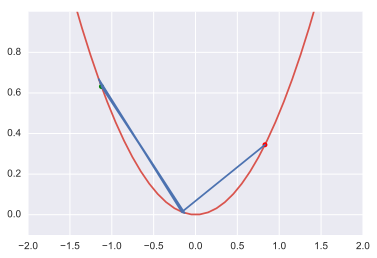

In [6]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


def minimize_step_alpha(f, x0, alpha):
    # Try moving left
    x1 = x0 + alpha
    if f(x1) < f(x0):
        return x1
    
    x1 = x0 - alpha
    return x1


@interact(alpha=widgets.FloatSlider(min=0,max=1,step=0.05,value=1))
def change_step_size(alpha):
    path, vals = repeat_minimize(norm, 10, lambda f, x0: minimize_step_alpha(f, x0, alpha))
    plot_repeat(path, vals)

## Can we do better? Gradients!

So, why moving to the left or to the right while trying to find the minium? That's exactly what the gradient tells us: the direction along which the function increases.

Thus if $\nabla f(x)$ is the gradient, $-\nabla f(x)$ is the direction it decreases in. For our function, which is Least Squares, we have:

$$\dfrac{\delta f(x)}{\delta x} = x$$

In [21]:
def grad(x):
    return x

def gradient_direction(f, grad, x, alpha):
    return -grad(x) * alpha

def x_or_random(x0):
    x0 = x0 if x0 is not None else np.random.sample((1,1))
    try:
        t = x0[0,0]
    except:
        x0 = np.asarray(x0).reshape((1,1))
    return x0

def gradient_minimize(f, grad, n, alpha, minimizer=gradient_direction, x0=None):
    x0 = x_or_random(x0)
    path = [x0]
    vals = [norm(x0)]
    for _ in range(n):
        # Add some noise for visualization purposes
        x1 = x0 + minimizer(f, grad, x0, alpha)
        
        print "Went from %f to %f" % (x0, x1)
        x0 = x1
        
        path.append(x0)
        vals.append(norm(x0))
        
    return np.array(path), np.array(vals)

Went from 0.989294 to -0.049465
Went from -0.049465 to 0.002473
Went from 0.002473 to -0.000124
Went from -0.000124 to 0.000006
Went from 0.000006 to -0.000000
Went from -0.000000 to 0.000000
Went from 0.000000 to -0.000000
Went from -0.000000 to 0.000000
Went from 0.000000 to -0.000000
Went from -0.000000 to 0.000000


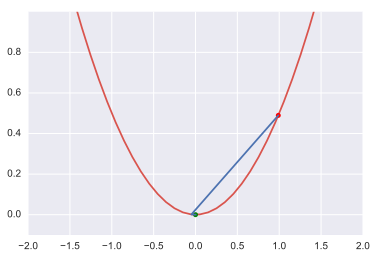

In [27]:
@interact(alpha=widgets.FloatSlider(min=0,max=1.5,step=0.05,value=1))
def change_step_size(alpha):
    path, vals = gradient_minimize(norm, grad, 10, alpha)
    plot_repeat(path, vals)

## Even better! Finding the best $\alpha$ automatically

Keep in mind, we want $f(x_1) < f(x_0)$, so we basically want:

$$x_1 = x_0 - \alpha \nabla f(x)$$

$$f(x_0 - \alpha \nabla f(x)) < f(x_0) $$

Algorithm:

$
    \text{Set an initial }\alpha_0 = 1\\
    \\
    \text{Do step }k\text{ out of }n\text{ steps:}\\
    \hspace{15pt}    \text{Compute }x_1\text{ from }x_0\\
    \hspace{15pt}    \text{If }f(x_1) < f(x_0)\text{ then} \\
    \hspace{30pt}        x_0 = x_1\\
    \hspace{30pt}        \alpha_k = \alpha_0\\
    \hspace{15pt}    \text{Else:}\\
    \hspace{30pt}        \alpha_k = 0.5 \alpha_k
$

That is, if the point we have found so far does not minimize the function, reduce the step size by a half. Of course, we could even improve it by setting a minimum $\alpha_k$.

In [23]:
def grad(x):
    return x

def gradient_direction(f, grad, x, alpha):
    return -grad(x) * alpha

def gradient_minimize_backtracking(f, grad, n, alpha0, alpha_epsilon=1e-6, minimizer=gradient_direction, x0=None):
    x0 = x_or_random(x0)
    path = [x0]
    vals = [norm(x0)]
    alpha = alpha0
    step = 0
    
    while step < n and alpha > alpha_epsilon:
        x1 = x0 + minimizer(f, grad, x0, alpha)
        
        if f(x1) < f(x0):
            alpha = alpha0
            print "Went from %f to %f" % (x0, x1)
            x0 = x1
        
            path.append(x0)
            vals.append(norm(x0))
        
            step += 1
        else:
            alpha *= 0.5
        
    return np.array(path), np.array(vals)

Went from 1.300000 to -0.747500
Went from -0.747500 to 0.429812
Went from 0.429812 to -0.247142
Went from -0.247142 to 0.142107
Went from 0.142107 to -0.081711
Went from -0.081711 to 0.046984
Went from 0.046984 to -0.027016
Went from -0.027016 to 0.015534
Went from 0.015534 to -0.008932
Went from -0.008932 to 0.005136


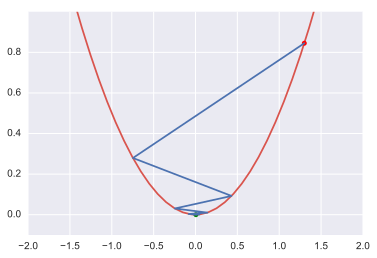

In [25]:
@interact(alpha=widgets.FloatSlider(min=0,max=10,step=0.05,value=1))
def change_step_size(alpha):
    path, vals = gradient_minimize_backtracking(norm, grad, 10, alpha, x0=1.3)
    plot_repeat(path, vals)